# HDCNN for Architecture Image Recognition

## Setup and Imports

**Get dataset**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!unzip -q /content/drive/MyDrive/135final/dataset.zip -d ./dataset

replace ./dataset/architectural-styles-dataset/Achaemenid architecture/000000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Import Packages**

In [9]:
import keras as kr
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()


from keras.datasets import cifar100

from sklearn.model_selection import train_test_split

from random import randint
import time
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
if not os.path.exists('models/'):
    os.mkdir('models')

**Define Global Variables**

In [11]:
# The number of coarse categories
coarse_categories = 11

# The number of fine categories
fine_categories = 25

## Import and Preprocess Dataset

In [12]:
import random
import keras_preprocessing.image

def load_and_crop_img(path, grayscale=False, color_mode='rgb', target_size=None,
             interpolation='nearest'):
    """Wraps keras_preprocessing.image.utils.loag_img() and adds cropping.
    Cropping method enumarated in interpolation
    # Arguments
        path: Path to image file.
        color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb".
            The desired image format.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        interpolation: Interpolation and crop methods used to resample and crop the image
            if the target size is different from that of the loaded image.
            Methods are delimited by ":" where first part is interpolation and second is crop
            e.g. "lanczos:random".
            Supported interpolation methods are "nearest", "bilinear", "bicubic", "lanczos",
            "box", "hamming" By default, "nearest" is used.
            Supported crop methods are "none", "center", "random".
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if interpolation method is not supported.
    """

    # Decode interpolation string. Allowed Crop methods: none, center, random
    interpolation, crop = interpolation.split(":") if ":" in interpolation else (interpolation, "none")  

    if crop == "none":
        return keras_preprocessing.image.utils.load_img(path, 
                                            grayscale=grayscale, 
                                            color_mode=color_mode, 
                                            target_size=target_size,
                                            interpolation=interpolation)

    # Load original size image using Keras
    img = keras_preprocessing.image.utils.load_img(path, 
                                            grayscale=grayscale, 
                                            color_mode=color_mode, 
                                            target_size=None, 
                                            interpolation=interpolation)

    # Crop fraction of total image
    crop_fraction = 0.875
    target_width = target_size[1]
    target_height = target_size[0]

    if target_size is not None:        
        if img.size != (target_width, target_height):

            if crop not in ["center", "random"]:
                raise ValueError('Invalid crop method {} specified.', crop)

            if interpolation not in keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS:
                raise ValueError(
                    'Invalid interpolation method {} specified. Supported '
                    'methods are {}'.format(interpolation,
                        ", ".join(keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS.keys())))
            
            resample = keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS[interpolation]

            width, height = img.size

            # Resize keeping aspect ratio
            # result shold be no smaller than the targer size, include crop fraction overhead
            target_size_before_crop = (target_width/crop_fraction, target_height/crop_fraction)
            ratio = max(target_size_before_crop[0] / width, target_size_before_crop[1] / height)
            target_size_before_crop_keep_ratio = int(width * ratio), int(height * ratio)
            img = img.resize(target_size_before_crop_keep_ratio, resample=resample)

            width, height = img.size

            if crop == "center":
                left_corner = int(round(width/2)) - int(round(target_width/2))
                top_corner = int(round(height/2)) - int(round(target_height/2))
                return img.crop((left_corner, top_corner, left_corner + target_width, top_corner + target_height))
            elif crop == "random":
                left_shift = random.randint(0, int((width - target_width)))
                down_shift = random.randint(0, int((height - target_height)))
                return img.crop((left_shift, down_shift, target_width + left_shift, target_height + down_shift))

    return img
  
keras_preprocessing.image.iterator.load_img = load_and_crop_img

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
fine_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=15,
    horizontal_flip=True,
    samplewise_std_normalization = True)
fine_dir = "/content/dataset/architectural-styles-dataset"
fine_img = fine_datagen.flow_from_directory(fine_dir,target_size=(64,64), batch_size=128, interpolation = 'lanczos:center', shuffle=False)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 10113 images belonging to 25 classes.


In [15]:
from tqdm import tqdm
fine_img.reset()
X_fine, y_fine = next(fine_img)
for i in tqdm(range(int(len(fine_img))-1)): #1st batch is already fetched before the for loop.
  img, label = next(fine_img)
  X_fine = np.append(X_fine, img, axis=0)
  y_fine = np.append(y_fine, label, axis=0)
print(X_fine.shape, y_fine.shape)

100%|██████████| 79/79 [02:37<00:00,  1.99s/it]

(10113, 64, 64, 3) (10113, 25)


**Split Training set into Training and Validation sets**

In [16]:
x_train, x_val, y_train, y_val = train_test_split(X_fine, y_fine, test_size=.2,random_state=1234)

In [ ]:
# import matplotlib.pyplot as plt
# from IPython.core.display import display, HTML

# for i in range(0,10):
#     image = x_train[i]
#     plt.imshow(image)
#     plt.show()
#     print(np.where(y_train[i] == 1)[0])


# for i in range(0,10):
#     image = x_val[i]
#     plt.imshow(image)
#     plt.show()
#     print(np.where(y_train[i] == 1)[0])

**Constructing CNN**

In [17]:
from keras import optimizers
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.models import Model

in_layer = Input(shape=(64,64, 3), dtype='float32', name='main_input')

net = Conv2D(64, 3, strides=1, padding='same', activation='relu')(in_layer)
net = BatchNormalization()(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(128, 3, strides=1, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.1)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(256, 3, strides=1, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.2)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(512, 3, strides=1, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.3)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Flatten()(net)

net = Dense(1024, activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.3)(net)
net = Dense(25, activation='softmax')(net)

Instructions for updating:
Colocations handled automatically by placer.


**Compile Model**

In [18]:
model = Model(inputs=in_layer,outputs=net)
adam_coarse = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= adam_coarse, loss='categorical_crossentropy', metrics=['accuracy'])
tbCallBack = kr.callbacks.TensorBoard(log_dir='./data/graph/relu_drop/', histogram_freq=0, write_graph=True, write_images=True)

In [19]:
batch = 128

**Train Model**

In [20]:
index= 0
step = 5
stop = 30


while index < stop:
    model.fit(x_train, y_train, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val), callbacks=[tbCallBack])
    index += step
    model.save_weights('data/models/model_coarse'+str(index))

save_index = index

Train on 8090 samples, validate on 2023 samples
Epoch 1/5
8090/8090 [==============================] - ETA: 0s - loss: 3.1737 - acc: 0.1749

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8090/8090 [==============================] - 21s 3ms/sample - loss: 3.1737 - acc: 0.1749 - val_loss: 7.9362 - val_acc: 0.0657
Epoch 2/5
8090/8090 [==============================] - 9s 1ms/sample - loss: 2.4121 - acc: 0.3105 - val_loss: 7.7103 - val_acc: 0.0598
Epoch 3/5
8090/8090 [==============================] - 9s 1ms/sample - loss: 2.0577 - acc: 0.3972 - val_loss: 6.6672 - val_acc: 0.0588
Epoch 4/5
8090/8090 [==============================] - 9s 1ms/sample - loss: 1.7183 - acc: 0.4826 - val_loss: 6.5687 - val_acc: 0.0603
Epoch 5/5
8090/8090 [==============================] - 9s 1ms/sample - loss: 1.3744 - acc: 0.5756 - val_loss: 4.7572 - val_acc: 0.1626
Train on 8090 samples, validate on 2023 samples
Epoch 6/10
8090/8090 [==============================] - 9s 1ms/sample - loss: 1.0151 - acc: 0.6789 - val_loss: 3.3258 - val_acc: 0.2585
Epoch 7/10
8090/8090 [==============================] - 9s 1ms/sample - loss: 0.6864 - acc: 0.7803 - val_loss: 2.8455 - val_acc: 0.3075
Epoch 8/10
809

In [21]:
index = save_index
stop = 100
while index < stop:
    model.fit(x_train, y_train, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val), callbacks=[tbCallBack])
    index += step
    model.save_weights('data/models/model_coarse'+str(index))

Train on 8090 samples, validate on 2023 samples
Epoch 31/35
8090/8090 [==============================] - 9s 1ms/sample - loss: 0.0158 - acc: 0.9959 - val_loss: 4.0359 - val_acc: 0.3950
Epoch 32/35
8090/8090 [==============================] - 9s 1ms/sample - loss: 0.0161 - acc: 0.9958 - val_loss: 3.8980 - val_acc: 0.4301
Epoch 33/35
8090/8090 [==============================] - 9s 1ms/sample - loss: 0.0149 - acc: 0.9963 - val_loss: 4.0858 - val_acc: 0.4128
Epoch 34/35
8090/8090 [==============================] - 9s 1ms/sample - loss: 0.0117 - acc: 0.9975 - val_loss: 4.1125 - val_acc: 0.4266
Epoch 35/35
8090/8090 [==============================] - 9s 1ms/sample - loss: 0.0501 - acc: 0.9842 - val_loss: 4.4752 - val_acc: 0.3940
Train on 8090 samples, validate on 2023 samples
Epoch 36/40
8090/8090 [==============================] - 9s 1ms/sample - loss: 0.0465 - acc: 0.9857 - val_loss: 4.2401 - val_acc: 0.3806
Epoch 37/40
8090/8090 [==============================] - 9s 1ms/sample - loss: 0.0

In [22]:
# adam_fine =  tf.keras.optimizers.Adam(learning_rate=0.0001)

# for i in range(len(model.layers)):
#     model.layers[i].trainable=False

In [56]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize(X, y_target):

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000,random_state=135,learning_rate=10.)
    low_dim_embs = tsne.fit_transform(X)
    labels = y_target.ravel()

    X, Y = low_dim_embs[:, 0], low_dim_embs[:, 1]

    classes = list(np.unique(labels))
    markers = 'os' * len(classes)
    colors = sns.color_palette("husl",len(classes))
    for x, y, s in zip(X, Y, labels):
        i = int(s)
        plt.scatter(x, y, marker=markers[i], c=[colors[i]], alpha=0.6)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    # plt.figure(figsize=(5,5))
    plt.title('Visualize last layer')

    plt.legend()
    plt.axis("off")

    plt.show()

In [46]:
model.layers[-3].output

<tf.Tensor 'batch_normalization_4/batchnorm/add_1:0' shape=(?, 1024) dtype=float32>

In [60]:
def cal_X_for_visual(i = -3):

    sub_model = Model(inputs = in_layer, outputs = model.layers[i].output) 
    last_layer_item = sub_model.predict(x_val,batch_size=batch)

    vis_X = last_layer_item.reshape(x_val.shape[0],-1)
    print(vis_X.shape)
    labels = y_val.argmax(axis = 1)
    print (labels.shape)    
    return vis_X,labels

-3


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(2023, 1024)
(2023,)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
No handles with labels found to put in legend.


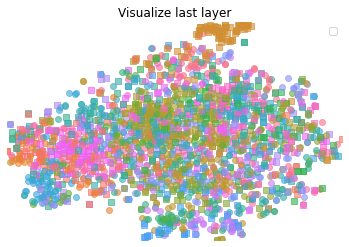

-4


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(2023, 1024)
(2023,)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
No handles with labels found to put in legend.


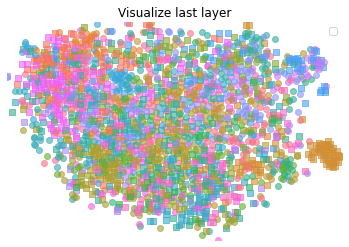

In [61]:
i=-3
print(i)
vis_X,labels=cal_X_for_visual(i)
visualize(vis_X,labels)

# i=-4
# print(i)
# vis_X,labels = cal_X_for_visual(i)
# visualize(vis_X,labels)